## Visualizing Profiling Traces with Open OnDemand (OOD)

This notebook contains example code and step-by-step instructions for visualizing profiled traces using Open OnDemand (OOD).

During the lecture, a single OOD session was used to both **generate** and **visualize** profiling traces on a GPU node. While this works for demonstration purposes, it is **not the recommended workflow**. In particular, OOD sessions should not be run on `gpu_course` nodes, as this is wasteful when many users do it simultaneously. Additionally, real training code typically does not live inside a Jupyter Notebook.

The correct workflow is therefore:
1. Run your training job on a GPU node and generate profiling traces during execution.
2. Store the generated traces.
3. Visualize those traces later using a lightweight OOD session, as demonstrated in this notebook.

To enable visualization, you will also need to run a port-forwarding command from your local machine to expose the TensorBoard interface securely. Instructions for this are provided below.

We begin by setting up the required imports and defining some basic configuration variables and import tensorboard. Please check the updated `requirements.tx` as your environment will need some new installations compared to the main branch of this repo.


In [1]:
import os
import subprocess
from tensorboard import manager
import random

CLUSTER_ADDRESS = 'snellius.surf.nl' 
# This is only required when running tensorboard on a cluster.
RAND_PORT = random.randint(6000, 8000)
print(f"Using port {RAND_PORT} for cluster")
# Change this to another local port to forward the Cluster (e.g. Snellius) port to.
LOCAL_PORT = 16006
print(f"Using port {LOCAL_PORT} as local port")

Using port 7105 for cluster
Using port 16006 as local port


## Cluster Configuration and Port Forwarding

Here, we import TensorBoard and define a few global variables, including the address of the cluster. This setup is intentionally generic and should be easily adaptable to other clusters. We also generate pseudo-random ports that will be used for port forwarding.

Port forwarding is the mechanism that allows you to securely access services running on a remote machine (such as a compute node in an HPC cluster) as if they were running locally on your own computer. In this case, it is used to expose the TensorBoard web interface—which runs on a remote node and listens on a specific port—through an SSH tunnel that forwards that remote port to a local port on your machine. This allows you to open TensorBoard in your local browser while all computation and logging remain on the cluster, without requiring the cluster to expose the service directly to the internet.

A useful analogy is to think of **IP or cluster addresses** (e.g. `snellius.surf.nl`) as *street addresses*, and **ports** as *apartment numbers* inside a building. The cluster node is a large apartment building (one street address), and many different services live inside it, each behind its own apartment door (port). TensorBoard lives behind one specific port. Normally, the building is locked from the outside. Port forwarding is like asking the concierge to temporarily forward any visitors that arrive at your local apartment number to the correct apartment inside the remote building. From your perspective, the service appears to be running locally, while it is in fact securely redirected to the cluster.

It is important that the ports you choose are not already in use, since only one service can bind to a given port at a time. For this reason, we generate a random port for the remote side. Feel free to change both the local and remote ports if you run into issues. Just remember to avoid ports in the range **0–1023**, as these are typically reserved for system services.


Below, I'll define a function you can use to help setting up Tensorboard and print the right command for you to perform the port-forwarding.

In [2]:
def launch_tensorboard(logdir: str):
    username = os.getenv("USER")

    hostname = subprocess.check_output(["hostname"]).decode().strip()

    os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

    TB_DIR = manager._get_info_dir()

    # Kill old TensorBoard sessions
    subprocess.call(
        ["pkill", "-9", "-u", username, "-f", "multiprocessing-fork"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
    )
    subprocess.call(
        ["pkill", "-9", "-u", username, "tensorboard"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
    )

    subprocess.call(
        ["rm", "-rf", f"{TB_DIR}/*.info"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
        shell=True,
    )

    # Launch TensorBoard silently
    subprocess.Popen(
        [
            "tensorboard",
            "--logdir", logdir,
            "--port", str(RAND_PORT),
            "--load_fast=false",
            "--bind_all",
        ],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
    )

    # Launch TensorBoard silently
    subprocess.Popen(
        [
            "tensorboard",
            "--logdir", logdir,
            "--port", str(RAND_PORT),
            "--load_fast=false",
            "--bind_all",
        ],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
    )

    print(
        f"\nTo open TensorBoard on another machine:\n"
        f"\t1. In a local shell, run:\n"
        f"\t   ssh -L {LOCAL_PORT}:{hostname}:{RAND_PORT} {username}@{CLUSTER_ADDRESS}\n"
        f"\t   (enter your password if prompted)\n\n"
        f"\t2. Open a browser (NOT Safari) and go to:\n"
        f"\t   http://localhost:{LOCAL_PORT}/\n\n"
        f"This is only required once; subsequent runs only require a refresh."
    )


## Establishing the SSH Tunnel

Running the function below will print an SSH command of the form:

```ssh -L {LOCAL_PORT}:{hostname}:{REMOTE_PORT} {username}@{CLUSTER_ADDRESS```


Executing this command in your **local terminal** (and authenticating as usual) will establish an SSH tunnel that forwards traffic between your local machine and the remote node.

Once the tunnel is active, you can open the following URL in your browser:
`http://localhost:{LOCAL_PORT}/`

For example, `http://localhost:6006/`.

This will open the TensorBoard interface and allow you to inspect the profiling traces. Make sure to use a supported browser (e.g. Chrome or Firefox).

Let’s test this setup using the VGG compiled profiling traces from the lecture.

**WARNING**: Do not upload your own traces to the GitHub repository as they can be quite large



In [ ]:
# Example from the lecture
launch_tensorboard("logs/vgg_compile")
# Or show the example from example_trace.py
# launch_tensorboard("logs/simple_test")


To open TensorBoard on another machine:
	1. In a local shell, run:
	   ssh -L 16006:gcn9.local.snellius.surf.nl:7105 scur1948@snellius.surf.nl
	   (enter your password if prompted)

	2. Open a browser (NOT Safari) and go to:
	   http://localhost:16006/

This is only required once; subsequent runs only require a refresh.


## Verifying the TensorBoard Connection

After running the printed command (for example):
```ssh -L 16006:gcn9.local.snellius.surf.nl:7520 scur1948@snellius.surf.nl``
in your local terminal and logging in successfully, the ports should be forwarded correctly.


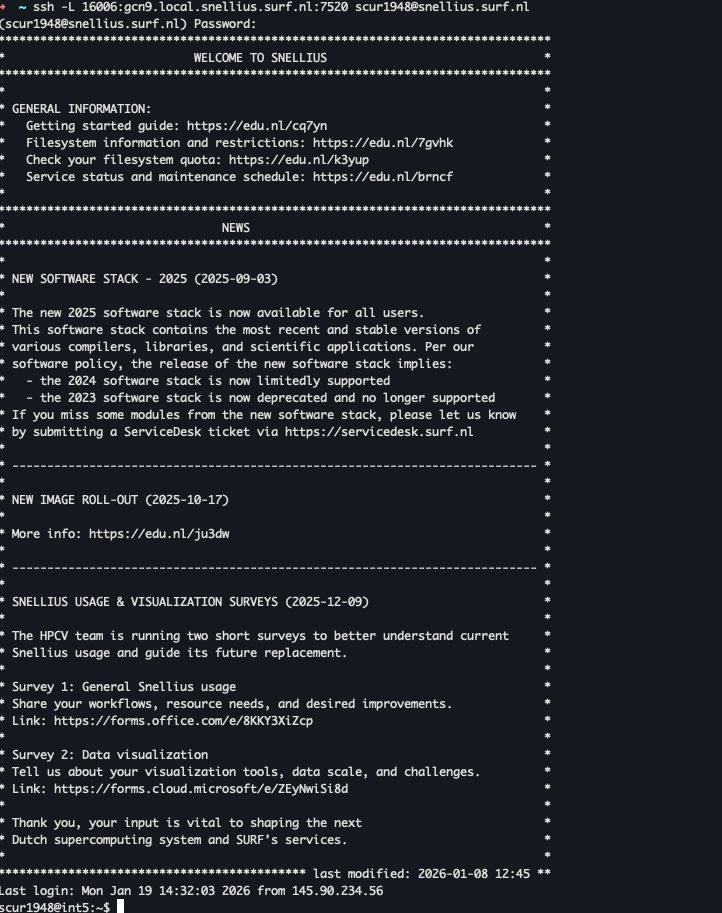

You can then open the following URL in your browser (Google Chrome in this case. NOT SAFARI!): 
http://localhost:16006/ (or a different port)

I can then open the URL (http://localhost:16006/.) in my browser (Google Chrome in this case), and I am greeted with the Tensorboard interface:
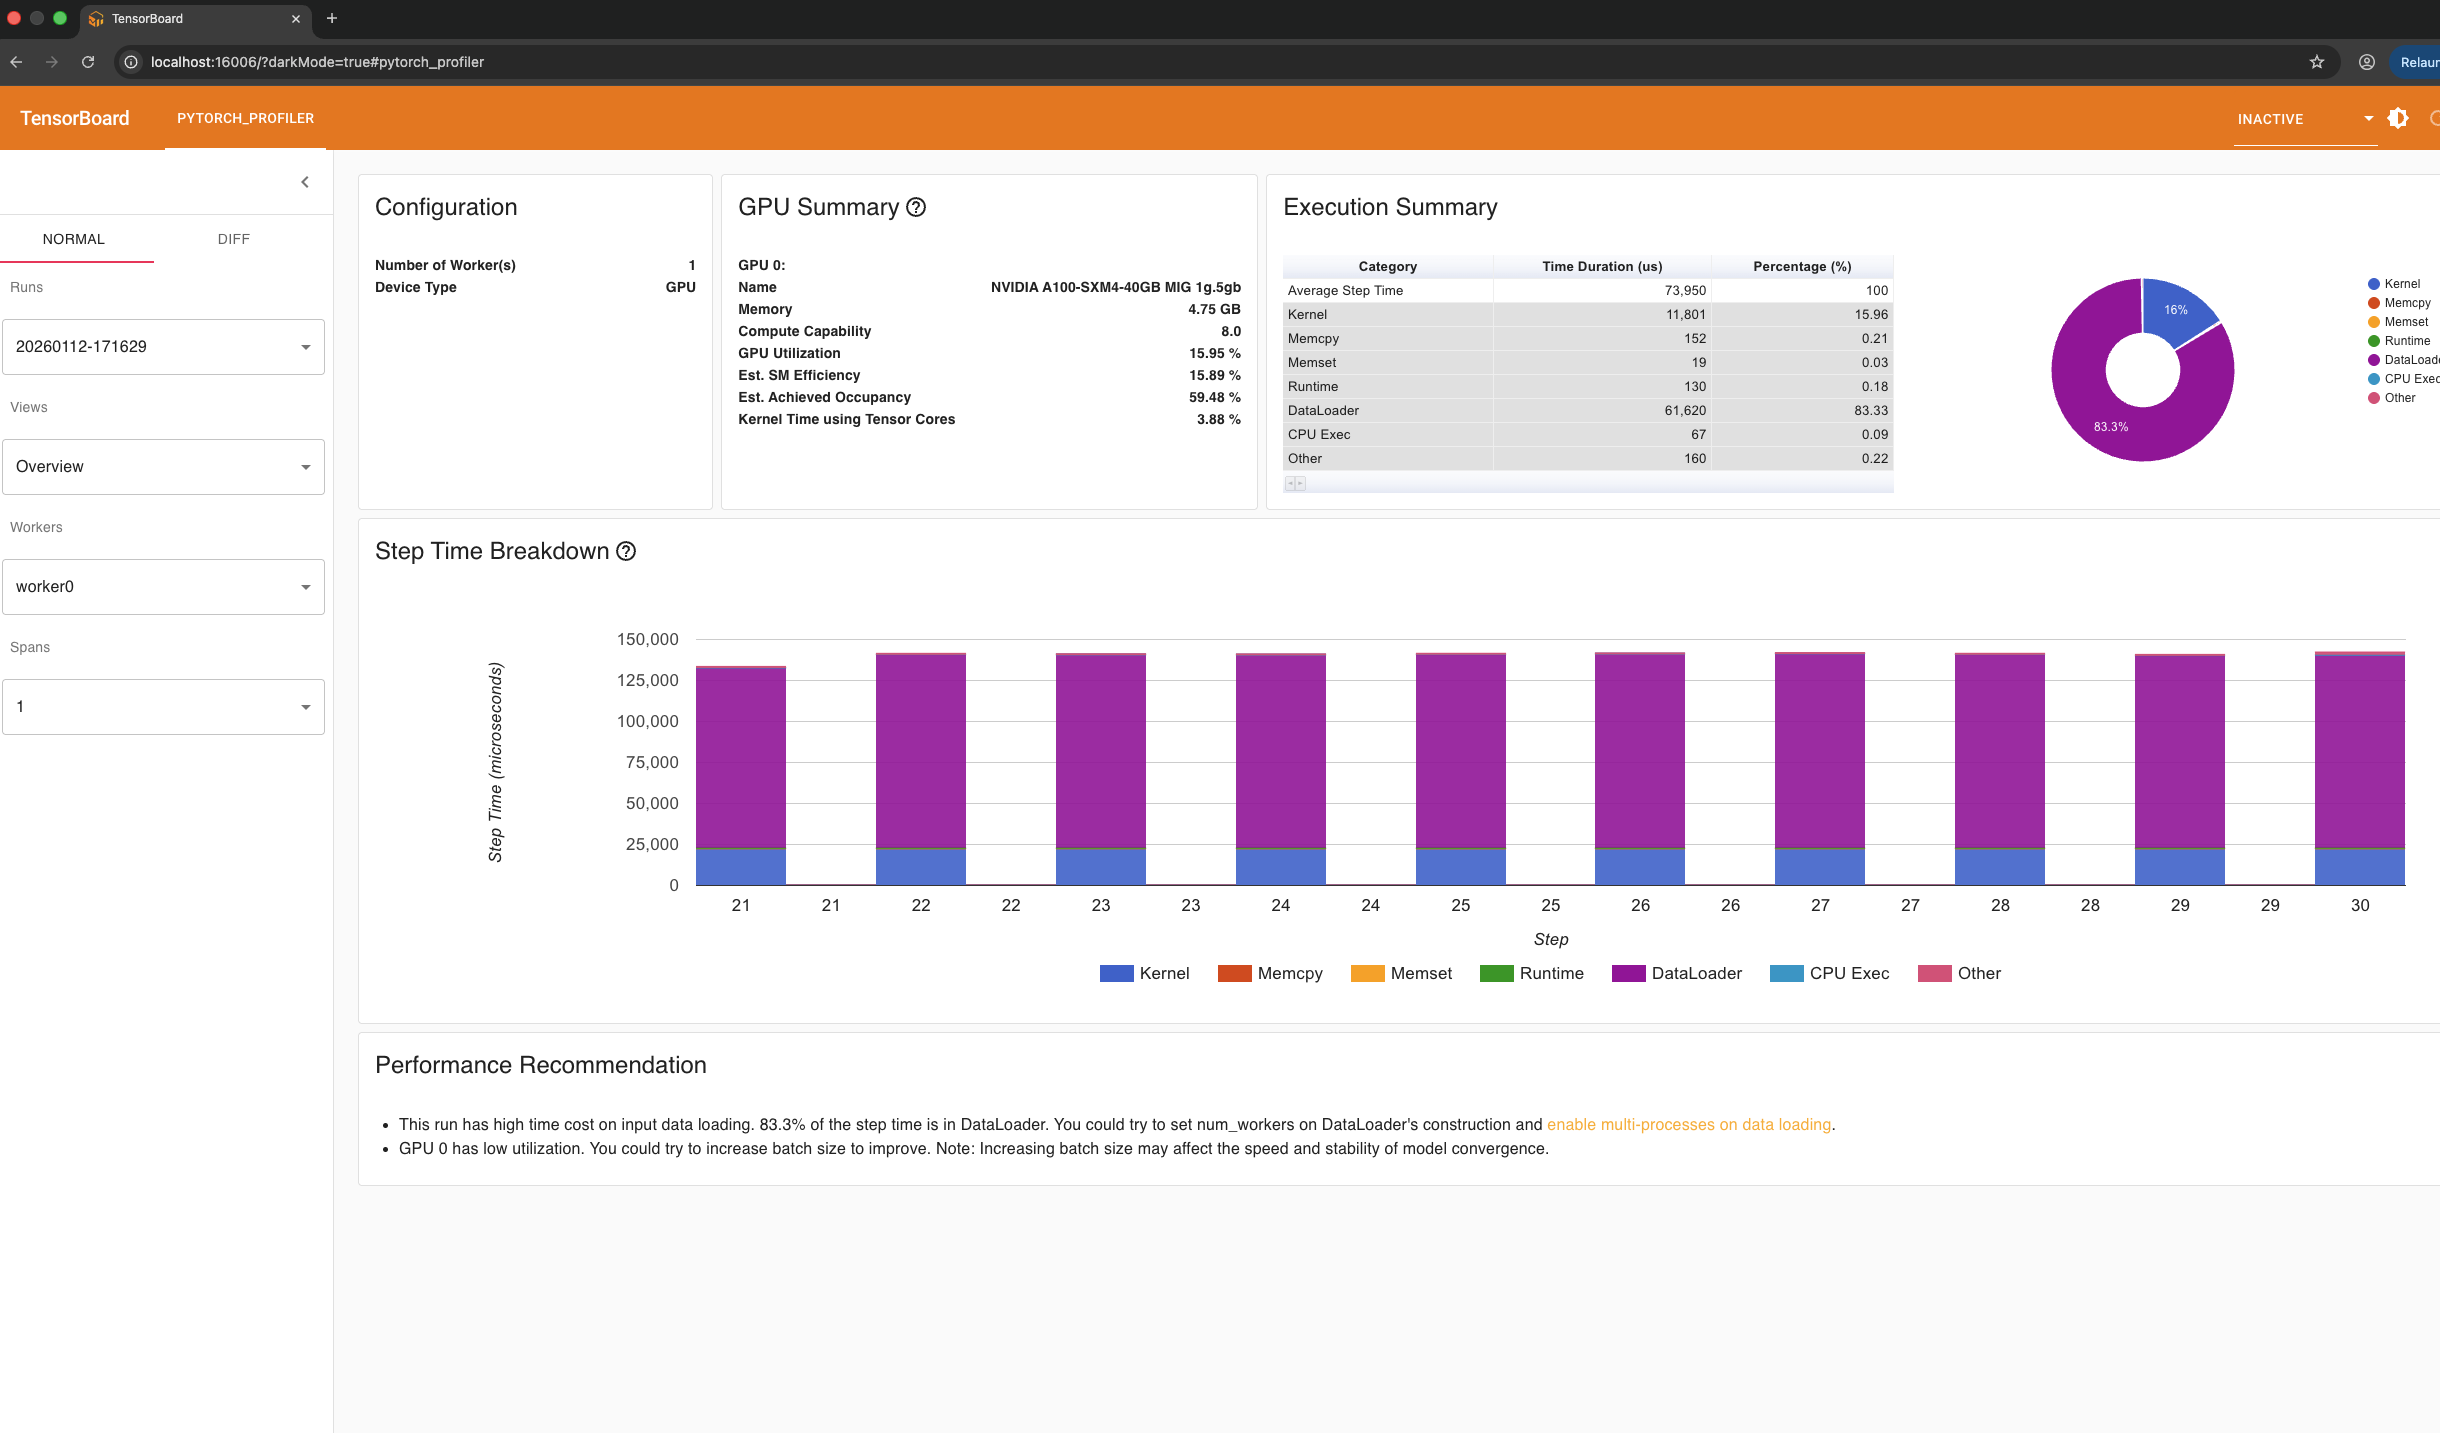